<a href="https://colab.research.google.com/github/TrueBalkar/Neural-network/blob/new-version/WinStart_TestTask_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip uninstall -y Kaggle
! pip install Kaggle
from google.colab import files
files.upload()

In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [4]:
! kaggle competitions download airbus-ship-detection

100% 28.6G/28.6G [05:41<00:00, 111MB/s]
100% 28.6G/28.6G [05:41<00:00, 89.7MB/s]


In [ ]:
! unzip /content/airbus-ship-detection

In [6]:
! rm airbus-ship-detection.zip

In [26]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU, Precision, Recall, BinaryAccuracy
from tensorflow.keras import backend as K

In [10]:
# Load data
path = "/content/"
masks = pd.read_csv(rf"{path}train_ship_segmentations_v2.csv")
print(f"train_ship_segmentations_v2.csv:\n\n{masks}")

train_ship_segmentations_v2.csv:

              ImageId                                      EncodedPixels
0       00003e153.jpg                                                NaN
1       0001124c7.jpg                                                NaN
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...               ...                                                ...
231718  fffedbb6b.jpg                                                NaN
231719  ffff2aa57.jpg                                                NaN
231720  ffff6e525.jpg                                                NaN
231721  ffffc50b4.jpg                                                NaN
231722  ffffe97f3.jpg                                                NaN

[231723 rows x 2 columns]


In [11]:
masks.describe

<bound method NDFrame.describe of               ImageId                                      EncodedPixels
0       00003e153.jpg                                                NaN
1       0001124c7.jpg                                                NaN
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...               ...                                                ...
231718  fffedbb6b.jpg                                                NaN
231719  ffff2aa57.jpg                                                NaN
231720  ffff6e525.jpg                                                NaN
231721  ffffc50b4.jpg                                                NaN
231722  ffffe97f3.jpg                                                NaN

[231723 rows x 2 columns]>

In [12]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
print(f"{unique_img_ids}")

              ImageId  ships
0       00003e153.jpg      0
1       0001124c7.jpg      0
2       000155de5.jpg      1
3       000194a2d.jpg      5
4       0001b1832.jpg      0
...               ...    ...
192551  fffedbb6b.jpg      0
192552  ffff2aa57.jpg      0
192553  ffff6e525.jpg      0
192554  ffffc50b4.jpg      0
192555  ffffe97f3.jpg      0

[192556 rows x 2 columns]


In [13]:
unique_img_ids['is_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

print(f"Count of images with/withot ships \n{unique_img_ids['is_ship'].value_counts()}")

Count of images with/withot ships 
0.0    150000
1.0     42556
Name: is_ship, dtype: int64


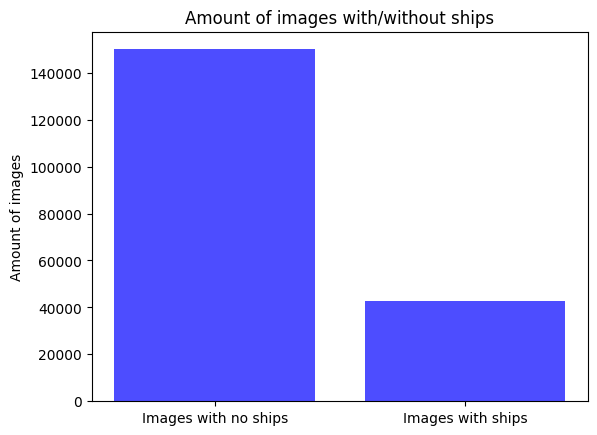

In [14]:
n_images_plot = unique_img_ids['is_ship'].value_counts()
x_pos = ['Images with no ships', 'Images with ships']
# Create bars and choose color
plt.bar(x_pos, n_images_plot, color = (0.3, 0.3, 1, 1))

plt.title('Amount of images with/without ships')
plt.ylabel('Amount of images')

plt.xticks(x_pos)

plt.show()

In [15]:
print(f"Count of images with number (1, 2, 3 etc.) of ships \n{unique_img_ids['ships'].value_counts()[1:]}")

Count of images with number (1, 2, 3 etc.) of ships 
1     27104
2      7674
3      2954
4      1622
5       925
6       657
7       406
8       318
9       243
10      168
11      144
12      124
14       76
13       75
15       66
Name: ships, dtype: int64


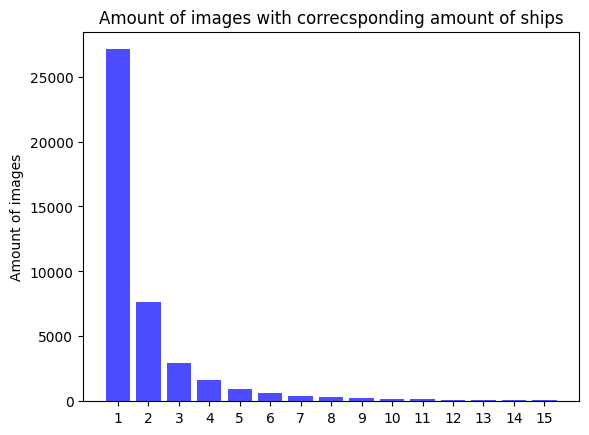

In [16]:
n_images_plot = unique_img_ids['ships'].value_counts()[1:]
x_pos = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
# Create bars and choose color
plt.bar(x_pos, n_images_plot, color = (0.3, 0.3, 1, 1))

plt.title('Amount of images with correcsponding amount of ships')
plt.ylabel('Amount of images')

plt.xticks(x_pos)

plt.show()

In [17]:
print(unique_img_ids)

              ImageId  ships  is_ship
0       00003e153.jpg      0      0.0
1       0001124c7.jpg      0      0.0
2       000155de5.jpg      1      1.0
3       000194a2d.jpg      5      1.0
4       0001b1832.jpg      0      0.0
...               ...    ...      ...
192551  fffedbb6b.jpg      0      0.0
192552  ffff2aa57.jpg      0      0.0
192553  ffff6e525.jpg      0      0.0
192554  ffffc50b4.jpg      0      0.0
192555  ffffe97f3.jpg      0      0.0

[192556 rows x 3 columns]


In [18]:
# Here you can choose how much ships do you want to see on an image - variable 'num_ships'
num_ships = 1
print(f"ImageId's with {num_ships} ships on it \n{unique_img_ids.loc[unique_img_ids.ships == num_ships, 'ImageId']}")

ImageId's with 1 ships on it 
2         000155de5.jpg
9         00031f145.jpg
12        00053c6ba.jpg
16        0005d6d95.jpg
17        0006c52e8.jpg
              ...      
192522    fff67c31a.jpg
192524    fff77c602.jpg
192528    fff909871.jpg
192543    fffcb6464.jpg
192547    fffdd2377.jpg
Name: ImageId, Length: 27104, dtype: object


In [19]:
# Here you can choose how much ships do you want to see on an image - variable 'num_ships'
num_ships = 8
print(f"ImageId's with {num_ships} ships on it \n{unique_img_ids.loc[unique_img_ids.ships == num_ships, 'ImageId']}")

ImageId's with 8 ships on it 
1985      02a608cf8.jpg
2610      0372121e8.jpg
2885      03d4bafb1.jpg
2902      03dc71fb4.jpg
2996      040073f20.jpg
              ...      
189535    fbfd0d840.jpg
190267    fcf2f2bd2.jpg
190287    fcf8aa709.jpg
191068    fe09d241c.jpg
192212    ff83ead39.jpg
Name: ImageId, Length: 318, dtype: object


In [20]:
# Here you can choose how much ships do you want to see on an image - variable 'num_ships'
num_ships = 15
print(f"ImageId's with {num_ships} ships on it \n{unique_img_ids.loc[unique_img_ids.ships == num_ships, 'ImageId']}")

ImageId's with 15 ships on it 
1208      01914baf2.jpg
1861      02776139a.jpg
2579      0368beab8.jpg
3183      0445b541d.jpg
3438      04a2c262a.jpg
              ...      
176401    ea9f82665.jpg
179547    eec04e7a8.jpg
186407    f7e6819bb.jpg
190392    fd1de824c.jpg
192184    ff7ac7f3c.jpg
Name: ImageId, Length: 66, dtype: object


In [21]:
# Function to encode mask
def rle_decode(mask_rle, IMG_SIZE = (768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 255 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(IMG_SIZE[0]*IMG_SIZE[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(IMG_SIZE).T

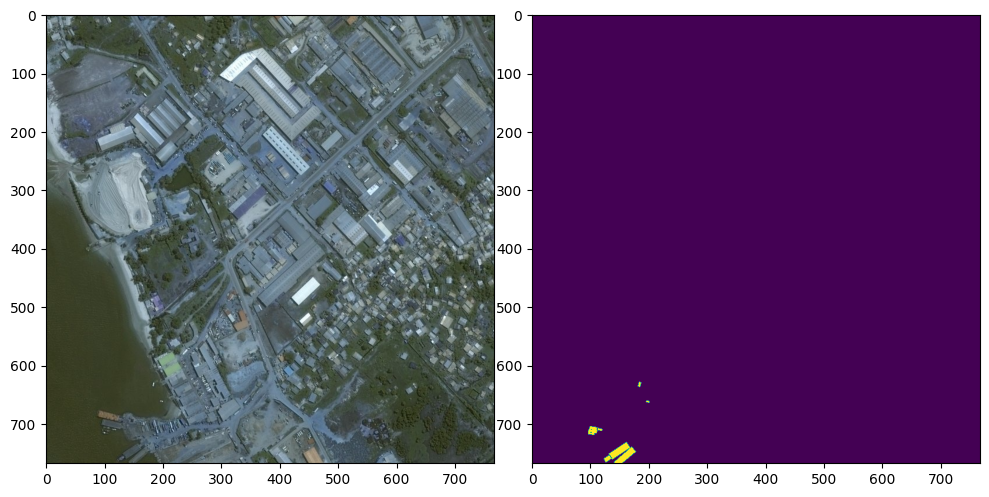

In [22]:
def display(ImageId):

    img = cv2.imread('/content/train_v2/' + ImageId)
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask, (768, 768))

    fig, axarr = plt.subplots(1, 2, figsize=(10, 20))
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks)
    plt.tight_layout(h_pad=0.1, w_pad=0.1) # to adjust automatically axis to subplot area
    plt.show()

display('00021ddc3.jpg')

In [23]:
def calculate_ship_area(encoded_pixels_data):
    if isinstance(encoded_pixels_data, float):
        results = {
            'ship_area': 0,
            'ship_height': 0,
            'ship_width': 0
        }
        return results
    encoded_pixels_data = [int(i) for i in encoded_pixels_data.split()[1::2]]
    ship_height = len(encoded_pixels_data)
    ship_width = max(encoded_pixels_data)
    ship_area = sum(encoded_pixels_data)
    results = {
        'ship_area': ship_area,
        'ship_height': ship_height,
        'ship_width': ship_width
    }
    return results

In [24]:
masks[['ship_area', 'ship_height', 'ship_width']] = 0
ship_data_details = masks['EncodedPixels'].apply(calculate_ship_area)
for column_name in ['ship_area', 'ship_height', 'ship_width']:
    masks[column_name] = ship_data_details.str[column_name]

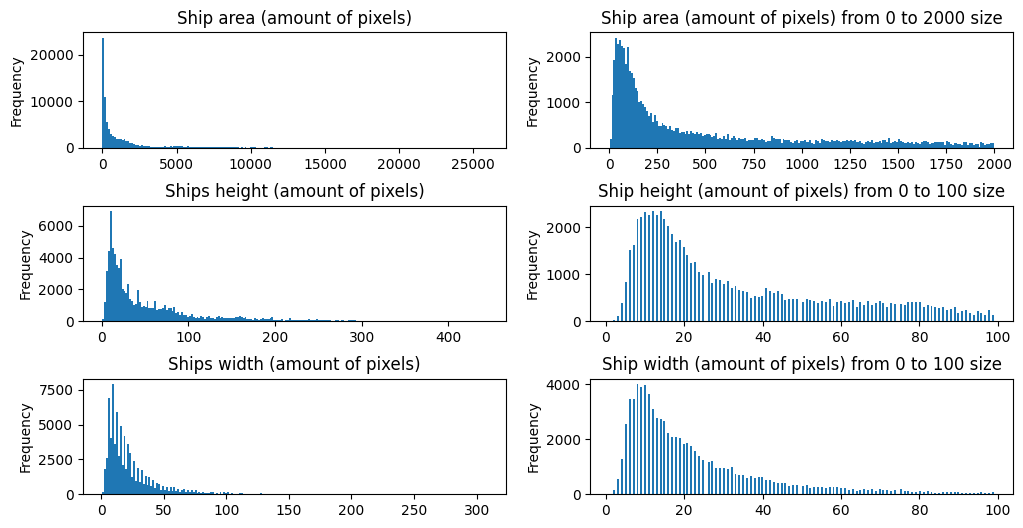

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

masks.where(masks['ship_area'] > 0)['ship_area'].plot(ax=axes[0, 0], title='Ship area (amount of pixels)', kind = 'hist', bins=200);
masks.where((masks['ship_area'] > 0) & (masks['ship_area'] < 2000))['ship_area'].plot(ax=axes[0, 1], title='Ship area (amount of pixels) from 0 to 2000 size', kind = 'hist', bins=200);

masks.where(masks['ship_height'] > 0)['ship_height'].plot(ax=axes[1, 0], title='Ships height (amount of pixels)', kind = 'hist', bins=200);
masks.where((masks['ship_height'] > 0) & (masks['ship_height'] < 100))['ship_height'].plot(ax=axes[1, 1], title='Ship height (amount of pixels) from 0 to 100 size', kind = 'hist', bins=200);

masks.where(masks['ship_width'] > 0)['ship_width'].plot(ax=axes[2, 0], title='Ships width (amount of pixels)', kind = 'hist', bins=200);
masks.where((masks['ship_width'] > 0) & (masks['ship_width'] < 100))['ship_width'].plot(ax=axes[2, 1], title='Ship width (amount of pixels) from 0 to 100 size', kind = 'hist', bins=200);

In [27]:
def unet_model_simplified(input_shape=(768, 768, 3)):
    # Define the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Contracting Path
    conv1 = layers.Conv2D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(8, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(16, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)

    # Expansive Path
    up6 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = layers.concatenate([up6, conv4], axis=-1)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv3], axis=-1)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = layers.concatenate([up8, conv2], axis=-1)
    conv8 = layers.Conv2D(16, 3, activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(8, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = layers.concatenate([up9, conv1], axis=-1)
    conv9 = layers.Conv2D(8, 3, activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(8, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [28]:
# Create the U-Net model
model = unet_model_simplified()

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 768, 768, 8)          224       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 768, 768, 8)          584       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 384, 384, 8)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

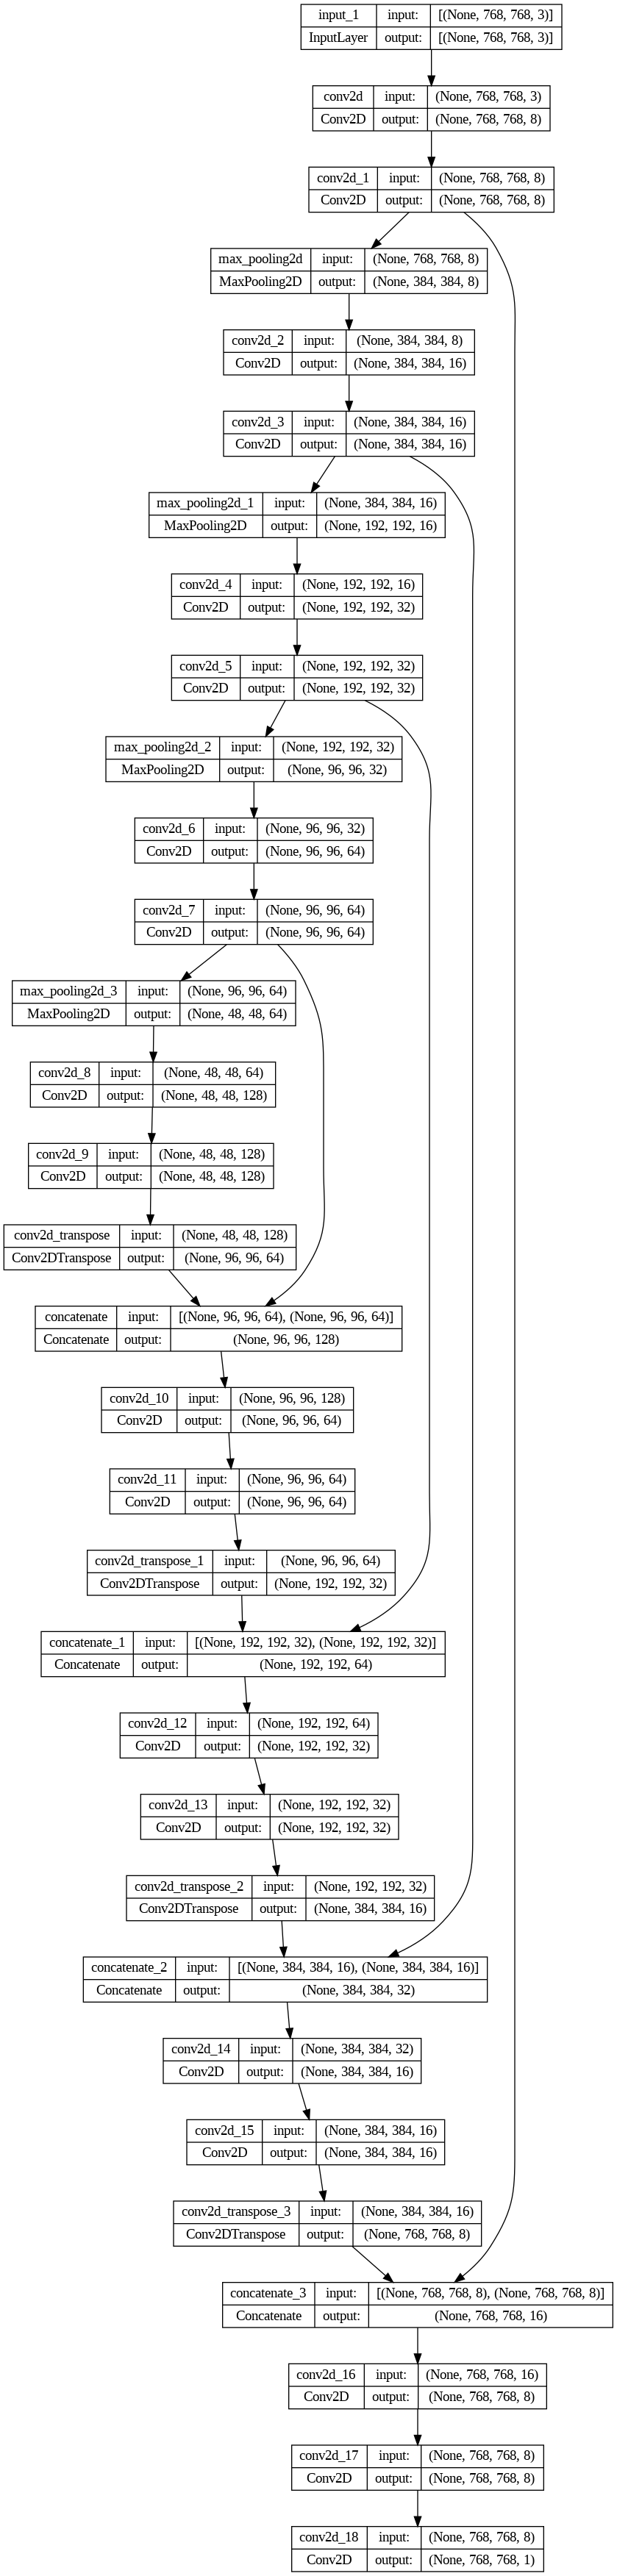

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)